# Capturing stillness in audience and music

Brouillon for evaluating how audience motion shifts in response to moments of musical stillness. 

    1. Load Stillness moments list
    2. Load measurements of audience motion
    3. Extract summary statistics for audience motion during piece(s): Mean, median, dispersion of some kind, distribution of values continuous?
    4. Evaluate motion around a Stillness moment identified 
    5. Evaluate motion around all moments identified for a piece
    6. test alignment (centre, previous onset, etc.)
    7. test stimulus factors
    8. test conditions (preceeding motion values. Is there a hard limit to how still they get?)

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import pingouin as pg

In [2]:
# import activity analysis functions from aa.py file in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport aa

In [3]:
%reload_ext autoreload

In [4]:
# NEW NO PD APPEND
def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and/or time_concert which is used to ID gaps greater than gap_T
    # gap_T is in milliseconds (ms)
    # rows of NaN data is added to non-time columns before the first sample, at edges of each gap, and after the last sample of data
    # these nans prevent interpolation errors through missing data
    cols = data.columns
    if 'time' in cols:
        time_col = 'time'
    if 'time_concert' in cols:
        time_col = 'time_concert'
        
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    dt = data[time_col].diff()    
    gapsi = np.array(dt[dt>gap_t].index)
    a = np.append(gapsi-1,dt.index[-1])
    gapsd = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsd[c] = data.loc[a,c]+dtdeltat
        if c.startswith('time'):
            gapsd[c] = data.loc[a,c]+deltat 

    a = np.append(gapsi,dt.index[0])
    gapsp = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsp[c] = data.loc[a,c]-dtdeltat
        if c.startswith('time'):
            gapsp[c] = data.loc[a,c]-deltat 

    data = pd.concat([gapsp,gapsd,data]).sort_values(time_col,ignore_index=True)
    return data

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [5]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / (fs/2)
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [6]:
pwd

'/Users/finn/Desktop/Current_Projects/Copen/CopenML_Analysis'

In [7]:
general_loc = '../'

public_mlmotion = general_loc + 'Public_data/Motion_ML/'
public_ax3 = general_loc +  'Public_data/Motion_AX3/'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'

In [8]:
concert_times = pd.read_csv(public_time +'Events_Main.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [9]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)

# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')


concert_times = pd.read_csv(public_time +'Events_Full.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format
concert_times['sequence'] = concert_times.index
concert_times.set_index('Datetime',inplace = True)
#concert_times.iloc[50:75]

In [10]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'].isin(['A']),:] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
#alignedParts

In [11]:
tic = time.time()
# load those motion traces 
# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 1000

for i,participant in alignedParts.iterrows():
    part = participant['Participant_Code']
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = gap_nans(inst_d,1000)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
#         f = interpolate.interp1d(datas['time'], datas[col],fill_value= 'previous')
        resampled[col] = f(ts_ct)
        
    # extract 1D accelerometer feature for easy comparison
    # and basic normalisation
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
    
    if part[2]=='R': # aligned AX3 correction factor (basic but verified for low motion conditions)
        aud_df[part] = b.copy()*6 
    else:
        aud_df[part] = b.copy()
        
aud_df.index = dt_ct
# ori_aud_df = aud_df.copy()
# ori_aud_df.index = (ts_ct/1000).round(1)

print(time.time()-tic)

76.78764081001282


In [12]:
Event_ranges = {'Beethoven 1':[8,9],'Beethoven 2':[9,10],'Beethoven 3':[10,11],'Beethoven 4':[11,12],'Schnittke 1':[17,18],'Schnittke 2':[18,19],'Schnittke 3':[19,20],'Bach':[28,29],'Folk 1':[33,34],'Folk 2':[35,36],'Folk 3':[38,39],'Folk 4':[41,42],'Folk 5':[44,45],'Folk 6':[50,51]}
aud_df.index = (ts_ct/1000).round(1)


In [13]:
seg_i = 1
seg_tag = 'Beethoven 1'
seg_start = Main_concert_times.iloc[Event_ranges[seg_tag][0],0]
seg_end = Main_concert_times.iloc[Event_ranges[seg_tag][1],0]
[seg_start,seg_end ]

[57.4, 476.08]

In [82]:
seg_tag = 'Full_Concert'
seg_start = Main_concert_times.iloc[8,0]
seg_end = Main_concert_times.iloc[51,0]
[seg_start,seg_end ]

[57.4, 8042.24]

In [15]:
seg_df = aud_df.loc[seg_start:seg_end].copy()
seg_df = seg_df.fillna(0)


In [85]:
#Stilling_Points-reTagged_flip.csv
Stillings = pd.read_csv('./data/Stilling_Points-reTagged_flip.csv')
#Stillings = pd.read_csv(general_loc + 'Stimuli/' + 'Stilling_Low.csv')
Stillings=Stillings.fillna(0)
Stillings= Stillings.set_index('TIME')
Still_times  = Stillings.loc[seg_start:seg_end].copy()
print(len(Still_times))
Still_times.iloc[-5:,:]

257


,LABEL,Set,Movement,cues,Type,Gap,Rest,Connect,Voices_dec,Note_rate_dec,...,Rubato,Rit,Fermata,Tempo_inc,Diminuendo,Fp/Fz,Cresc,Precision,end,OLDTIME
TIME,,,,,,,,,,,,,,,,,,,,,
7744.49,67.50,8,1,2.0,end,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,7744.90
7916.48,62.25,9,1,1.0,retract,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,7916.20
7943.42,86.25,9,1,1.0,drop,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7942.63
8026.20,160.25,9,1,0.0,retract,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,8025.96
8041.96,173.00,9,1,1.0,end,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,8042.22


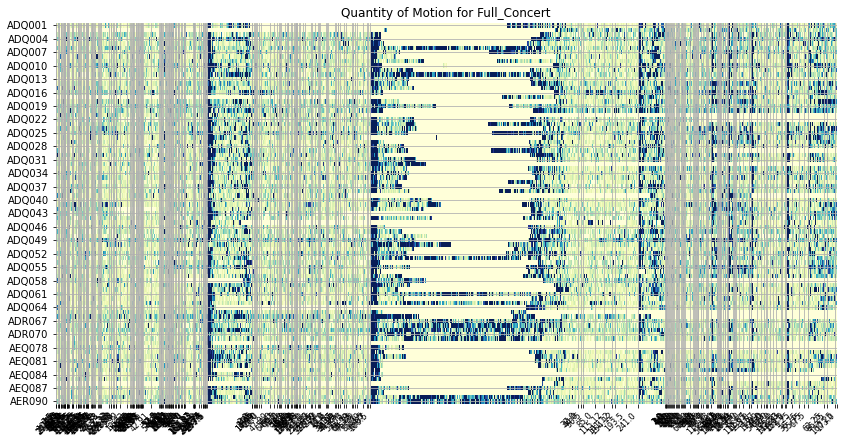

In [27]:
fig, (ax1) = plt.subplots(1, 1,figsize = [14,7])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu")
new_xticks = len(seg_df)*(Still_times.index - seg_start)/(seg_end-seg_start)
plt.xticks(new_xticks,Still_times['LABEL'], rotation='45',fontsize=8, ha='right')
plt.grid()
plt.title('Quantity of Motion for ' + seg_tag)
#plt.savefig('./Plots/qom_n_full.png',dpi = 300)
plt.show()


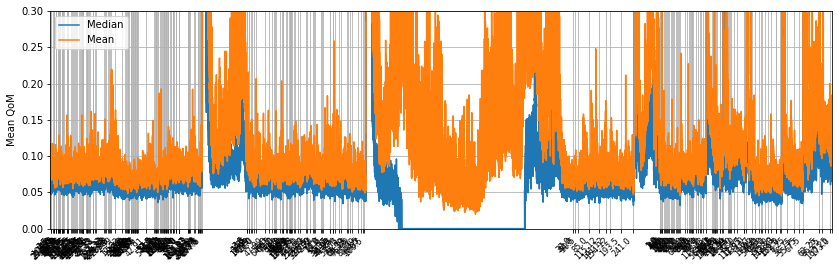

In [28]:
fig, (ax1) = plt.subplots(1, 1,figsize = [14,4])
seg_df.median(axis=1).plot(ax=ax1,label='Median')
seg_df.mean(axis=1).plot(ax=ax1,label='Mean')
plt.xticks(Still_times.index,Still_times.LABEL, rotation='45',fontsize=8, ha='right')
plt.xlim([seg_start,seg_end])
plt.ylim([0,0.3])
plt.ylabel('Mean QoM')
plt.grid()
plt.legend()
plt.show()

In [86]:
preoff = -3
postoff = 0

[-0.00467311029941106, 0.001314263471360692]


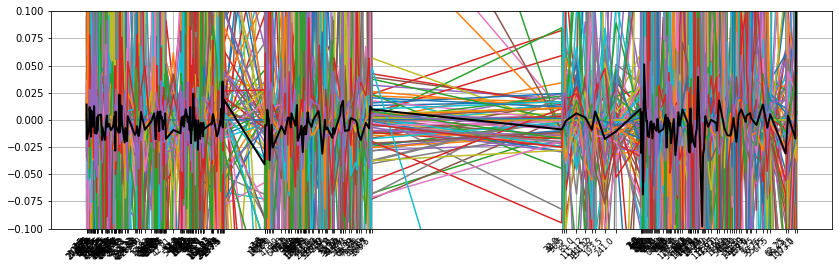

[0.5058823529411764, 0.07610483636278112]


In [87]:
fig,ax = plt.subplots(1,1,figsize=[14,4] )
V = pd.DataFrame(columns = seg_df.columns)
k = []
for i in range(len(Still_times)):
    sm = Still_times.iloc[i,:]
    Otime = sm.name
    pre_snip_df = seg_df.loc[Otime+preoff:Otime+preoff+1.0].mean(axis=0).values
    post_snip_df = seg_df.loc[Otime+postoff:Otime+postoff+1.0].mean(axis=0).values
    V.loc[Otime,:] = post_snip_df-pre_snip_df
    k.append(sum((post_snip_df-pre_snip_df)<0)/len(pre_snip_df))

V.plot(legend=False,ax=ax)
V.mean(axis=1).plot(ax=ax,color='k',linewidth=2)
plt.xticks(Still_times.index,Still_times.LABEL, rotation='45',fontsize=8, ha='right')
print([V.mean(axis=1).median(),V.mean(axis=1).sem()])
plt.ylim([-0.1,0.1])
plt.grid()
plt.show()
print([np.median(np.array(k)),np.std(np.array(k))])


In [89]:
Still_times['Ratio'] = k

In [41]:
Still_times.loc[Still_times['end'].isin([1.0]),:]

,LABEL,Set,Movement,cues,Type,Gap,Rest,Connect,Voices_dec,Note_rate_dec,...,Rit,Fermata,Tempo_inc,Diminuendo,Fp/Fz,Cresc,Precision,end,OLDTIME,Ratio
TIME,,,,,,,,,,,,,,,,,,,,,
457.63,193.25,1,1,2.0,end,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,457.63,0.588235
672.59,272.33,1,2,1.0,end,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,672.59,0.517647
1152.88,55.00,1,3,1.0,end,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1152.88,0.541176
1608.51,277.50,1,4,2.0,end,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1608.51,0.364706
2407.35,83.00,2,1,2.0,end,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2408.91,0.470588
2747.13,326.99,2,2,1.0,end,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2747.47,0.529412
3266.45,100.50,2,3,0.0,end,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3266.45,0.458824
6011.51,241.00,3,1,2.0,end,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6011.32,0.564706
6490.90,20.00,4,1,1.0,end,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,6490.90,0.552941


In [36]:
Still_times.loc[Still_times['LABEL'].isin(['e']),:]

,LABEL,Set,Movement,Moment,Since,Type,end,Sequence,Rest,Gap,...,Cresc,Fp,Diminuendo,TextDec,Drone,TextInc,revisedT,old_TIME,old_Ratio,Ratio
TIME,,,,,,,,,,,,,,,,,,,,,
1608.510000,e,1,4,112,24.93,0,2.0,0.0,1,1,...,1,0,0,0,0,0,0,1608.51,0.373913,0.470588
3266.450000,e,2,3,165,19.28,Low_Rest,0.0,0.0,1,1,...,0,0,1,0,0,0,0,3266.45,0.443478,0.458824
6011.506667,e,3,1,174,126.19,Low_Rest,0.0,0.0,0,1,...,0,0,0,1,0,0,1,6011.32,0.521739,0.552941
6757.373333,e,4,3,208,28.47,Low_Rest,0.0,0.0,1,1,...,0,0,1,1,0,0,1,6757.59,0.495652,0.505882
6932.500000,e,5,1,219,14.19,Low_Rest,2.0,0.0,1,1,...,1,0,0,0,0,0,0,6932.50,0.286957,0.388235
7169.040000,e,6,1,228,26.38,Low_Rest,2.0,0.0,1,1,...,0,1,0,0,0,0,1,7169.34,0.286957,0.517647
7527.613333,e,7,1,239,8.27,Low_Rest,0.0,0.0,1,1,...,0,0,1,1,0,0,1,7525.88,0.373913,0.517647
7744.490667,e,8,1,243,33.21,Low_Rest,0.0,0.0,1,1,...,0,0,1,0,0,0,1,7744.90,0.426087,0.458824
8041.962667,e,8,1,247,16.26,Low_Rest,2.0,0.0,1,1,...,0,1,0,0,0,0,1,8042.22,0.000000,0.423529


In [90]:
Part_Still = Still_times.loc[~Still_times['LABEL'].isin(['e']),:] # in person hall participant
mean_dec = 0.47058823529411764 #V_df ,mean
Part_Still = Part_Still.loc[Part_Still['Ratio']>mean_dec,:]
#Part_Still = Part_Still.loc[~Part_Still['LABEL'].isin(['e-1']),:] # in person hall participant
#Part_Still = Part_Still.loc[Part_Still['Gap']>0,:].reset_index(drop = True) # with aligned motion measurements
Part_Still

,LABEL,Set,Movement,cues,Type,Gap,Rest,Connect,Voices_dec,Note_rate_dec,...,Rit,Fermata,Tempo_inc,Diminuendo,Fp/Fz,Cresc,Precision,end,OLDTIME,Ratio
TIME,,,,,,,,,,,,,,,,,,,,,
65.84,4.500,1,1,3.0,pause,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,65.84,0.564706
79.02,10.250,1,1,3.0,pause,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,79.02,0.588235
88.75,13.000,1,1,3.0,close,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,88.26,0.517647
111.57,25.625,1,1,1.0,trade,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111.57,0.505882
115.11,27.625,1,1,1.0,trade,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.11,0.494118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7297.17,37.000,7,1,1.0,hold,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,7297.17,0.505882
7315.43,46.000,7,1,0.0,place,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7315.43,0.564706
7468.76,138.000,7,1,1.0,drift,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,7468.76,0.494118


In [92]:
print([Still_times['Ratio'].median(),Still_times['Ratio'].sem(),len(Still_times)])
print([Part_Still['Ratio'].median(),Part_Still['Ratio'].sem(),len(Part_Still)])
###

# [0.5058823529411764, 0.0043855972389143655] 
# [0.5176470588235295, 0.0043902623378498555] Removing the ends of works, pre appalause, raises the ratio

[0.5058823529411764, 0.004756552272673819, 257]
[0.5411764705882353, 0.003354515225505954, 162]


In [44]:
sum((post_snip_df-pre_snip_df)<0)/len(pre_snip_df)

0.4235294117647059

In [46]:
print(Part_Still.columns)
Part_Still=Part_Still.fillna(0)
Part_Still

Index(['LABEL', 'Set', 'Movement', 'cues', 'Type', 'Gap', 'Rest', 'Connect',
       'Voices_dec', 'Note_rate_dec', 'Drone', 'TextInc', 'Phr_end',
       'Phr_begining', 'Elide', 'Sequence', 'Rubato', 'Rit', 'Fermata',
       'Tempo_inc', 'Diminuendo', 'Fp/Fz', 'Cresc', 'Precision', 'end',
       'OLDTIME', 'Ratio'],
      dtype='object')


,LABEL,Set,Movement,cues,Type,Gap,Rest,Connect,Voices_dec,Note_rate_dec,...,Rit,Fermata,Tempo_inc,Diminuendo,Fp/Fz,Cresc,Precision,end,OLDTIME,Ratio
TIME,,,,,,,,,,,,,,,,,,,,,
65.84,4.500,1,1,3.0,pause,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,65.84,0.564706
79.02,10.250,1,1,3.0,pause,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,79.02,0.588235
88.75,13.000,1,1,3.0,close,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,88.26,0.517647
111.57,25.625,1,1,1.0,trade,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111.57,0.505882
115.11,27.625,1,1,1.0,trade,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.11,0.494118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7297.17,37.000,7,1,1.0,hold,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,7297.17,0.505882
7315.43,46.000,7,1,0.0,place,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7315.43,0.564706
7468.76,138.000,7,1,1.0,drift,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,7468.76,0.494118


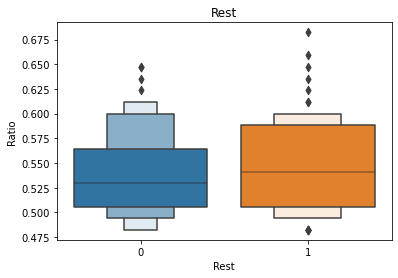

  Source  ddof1  ddof2         F     p-unc       np2
0   Rest      1    160  3.066083  0.081858  0.018803


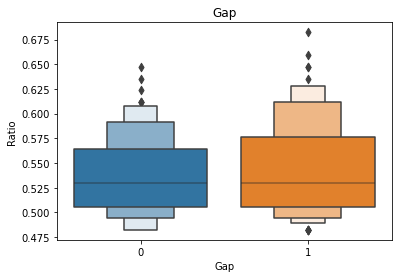

  Source  ddof1  ddof2         F     p-unc       np2
0    Gap      1    160  1.444828  0.231136  0.008949


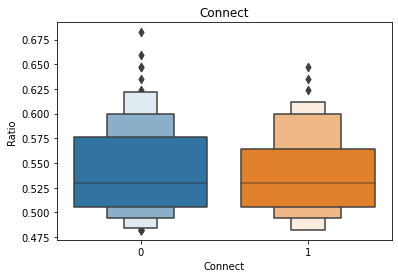

    Source  ddof1  ddof2         F     p-unc       np2
0  Connect      1    160  0.403536  0.526176  0.002516


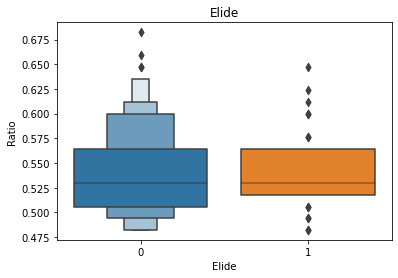

  Source  ddof1  ddof2         F     p-unc       np2
0  Elide      1    160  0.187179  0.665858  0.001169


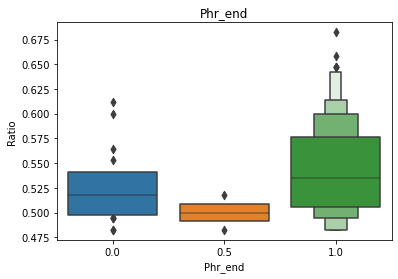

    Source  ddof1  ddof2         F     p-unc      np2
0  Phr_end      2    159  2.292625  0.104331  0.02803


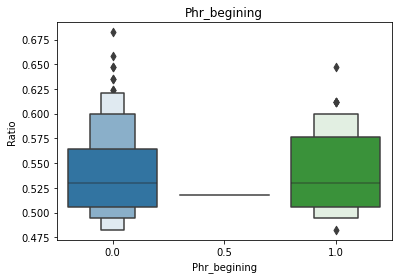

         Source  ddof1  ddof2         F    p-unc       np2
0  Phr_begining      2    159  0.160624  0.85175  0.002016


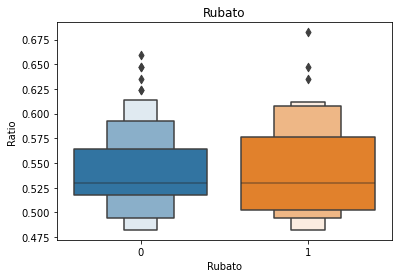

   Source  ddof1  ddof2         F     p-unc       np2
0  Rubato      1    160  0.011983  0.912969  0.000075


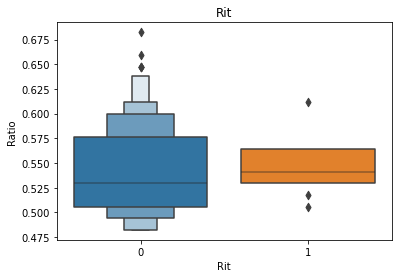

  Source  ddof1  ddof2         F     p-unc       np2
0    Rit      1    160  0.236145  0.627669  0.001474


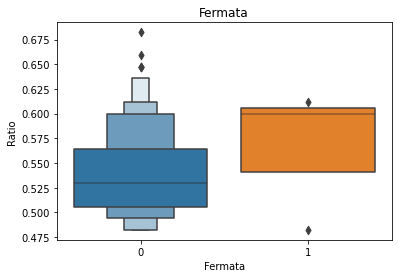

    Source  ddof1  ddof2         F     p-unc       np2
0  Fermata      1    160  0.791407  0.375011  0.004922


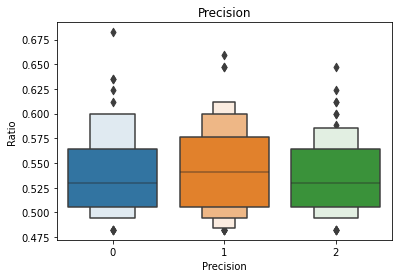

      Source  ddof1  ddof2       F     p-unc       np2
0  Precision      2    159  0.2109  0.810081  0.002646


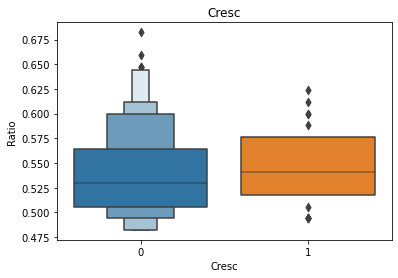

  Source  ddof1  ddof2         F     p-unc       np2
0  Cresc      1    160  0.495611  0.482458  0.003088


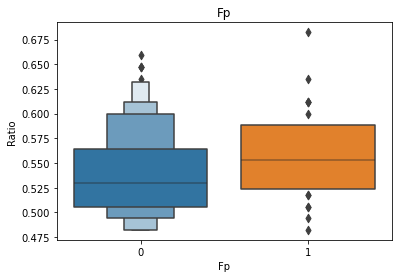

  Source  ddof1  ddof2         F     p-unc      np2
0     Fp      1    160  4.008345  0.046965  0.02444


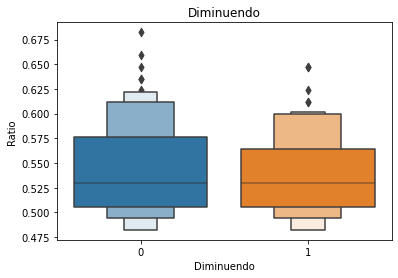

       Source  ddof1  ddof2         F     p-unc       np2
0  Diminuendo      1    160  0.403536  0.526176  0.002516


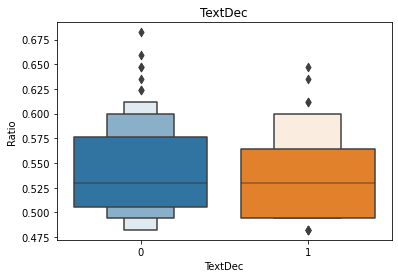

    Source  ddof1  ddof2        F     p-unc       np2
0  TextDec      1    160  0.56791  0.452198  0.003537


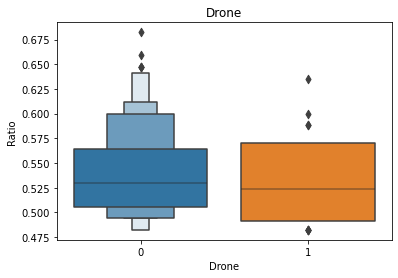

  Source  ddof1  ddof2         F     p-unc      np2
0  Drone      1    160  0.396151  0.529981  0.00247


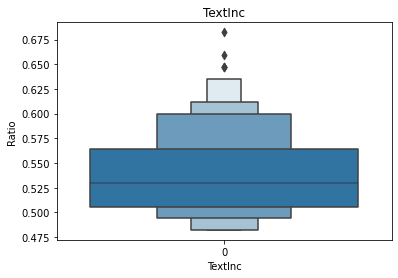

    Source  ddof1  ddof2    F           np2
0  TextInc      0    161  inf  6.223182e-30


/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pingouin/parametric.py:960: RuntimeWarning: divide by zero encountered in double_scalars
  msbetween = ssbetween / ddof1


In [50]:
features = ['Rest', 'Gap', 'Connect', 'Elide', 'Phr_end',
       'Phr_begining', 'Rubato', 'Rit', 'Fermata', 'Precision', 'Cresc', 'Fp',
       'Diminuendo', 'TextDec', 'Drone', 'TextInc']
for feat in features:
#feat = 'Gap'
    sns.boxenplot(x = feat,y = 'Ratio', data = Part_Still)
    plt.title(feat)
    plt.show()

    print(pg.anova(dv="Ratio",between = feat, data=Part_Still))

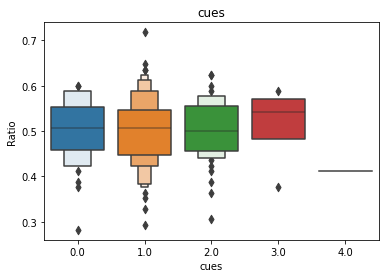

  Source  ddof1  ddof2         F     p-unc       np2
0   cues      4    252  0.425265  0.790345  0.006705


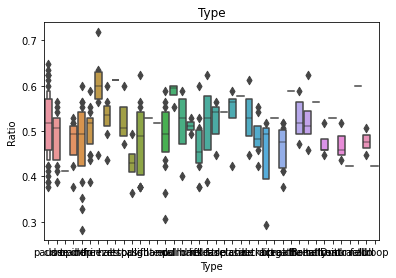

  Source  ddof1  ddof2         F     p-unc       np2
0   Type     39    217  1.671192  0.011806  0.230978


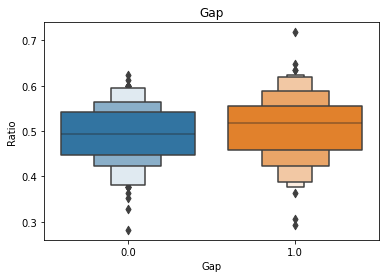

  Source  ddof1  ddof2         F    p-unc       np2
0    Gap      1    255  2.535935  0.11252  0.009847


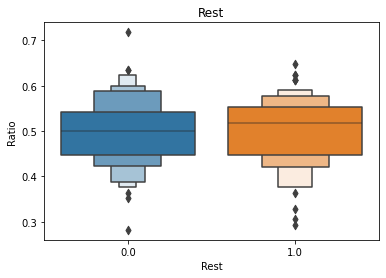

  Source  ddof1  ddof2         F     p-unc       np2
0   Rest      1    255  0.061421  0.804464  0.000241


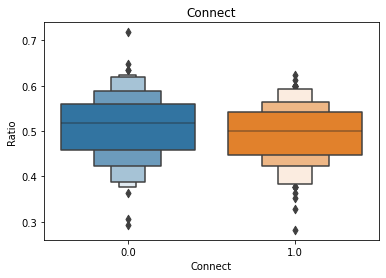

    Source  ddof1  ddof2         F     p-unc       np2
0  Connect      1    255  2.840739  0.093125  0.011017


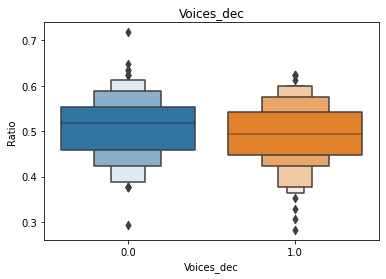

       Source  ddof1  ddof2         F     p-unc       np2
0  Voices_dec      1    255  3.194278  0.075084  0.012372


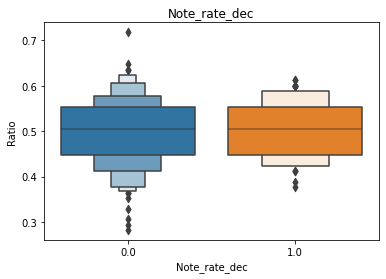

          Source  ddof1  ddof2         F     p-unc       np2
0  Note_rate_dec      1    255  0.068378  0.793924  0.000268


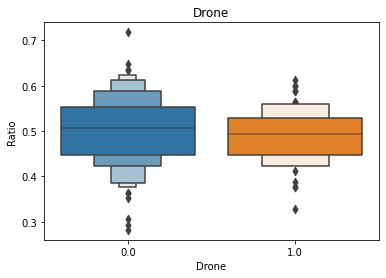

  Source  ddof1  ddof2         F     p-unc       np2
0  Drone      1    255  1.829971  0.177329  0.007125


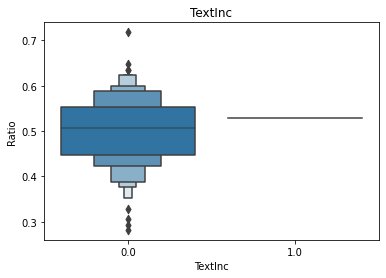

    Source  ddof1  ddof2         F     p-unc       np2
0  TextInc      1    255  0.169359  0.681028  0.000664


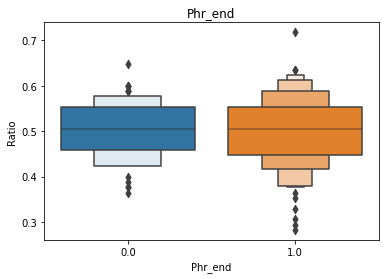

    Source  ddof1  ddof2         F    p-unc       np2
0  Phr_end      1    255  0.270855  0.60321  0.001061


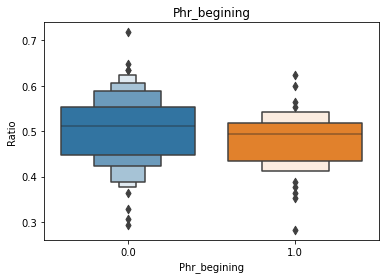

         Source  ddof1  ddof2         F     p-unc       np2
0  Phr_begining      1    255  4.772299  0.029832  0.018371


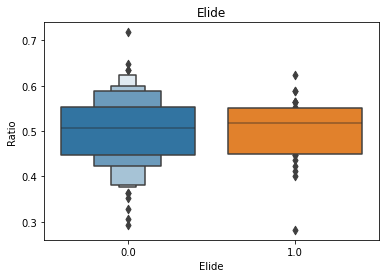

  Source  ddof1  ddof2         F     p-unc       np2
0  Elide      1    255  0.001039  0.974313  0.000004


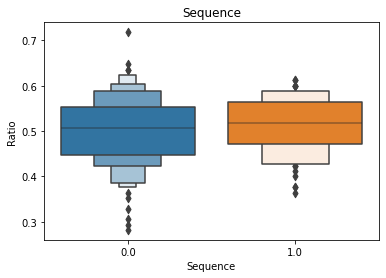

     Source  ddof1  ddof2         F     p-unc      np2
0  Sequence      1    255  1.211947  0.271985  0.00473


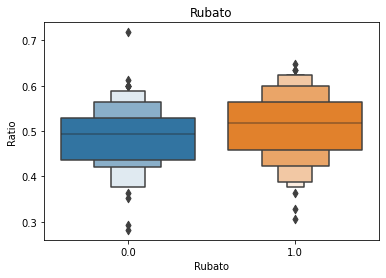

   Source  ddof1  ddof2        F     p-unc       np2
0  Rubato      1    255  8.02805  0.004974  0.030522


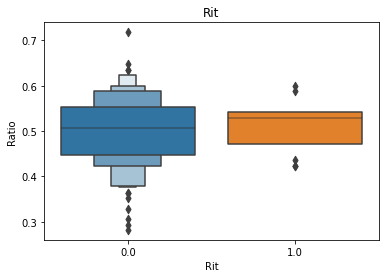

  Source  ddof1  ddof2         F     p-unc       np2
0    Rit      1    255  0.461217  0.497672  0.001805


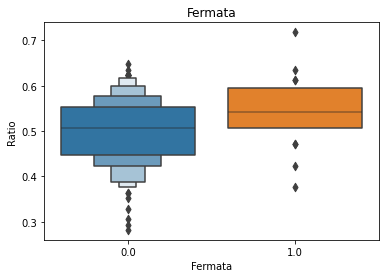

    Source  ddof1  ddof2         F     p-unc       np2
0  Fermata      1    255  6.412312  0.011934  0.024529


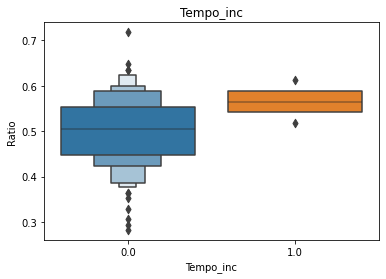

      Source  ddof1  ddof2         F     p-unc       np2
0  Tempo_inc      1    255  1.653994  0.199583  0.006444


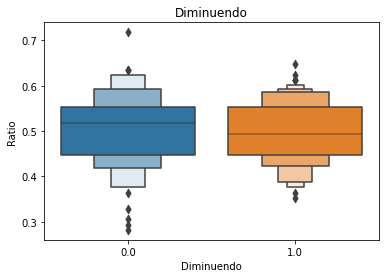

       Source  ddof1  ddof2         F     p-unc      np2
0  Diminuendo      1    255  0.114925  0.734884  0.00045


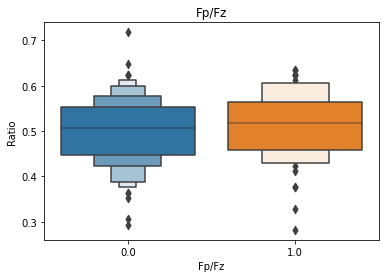

  Source  ddof1  ddof2         F     p-unc       np2
0  Fp/Fz      1    255  0.922187  0.337811  0.003603


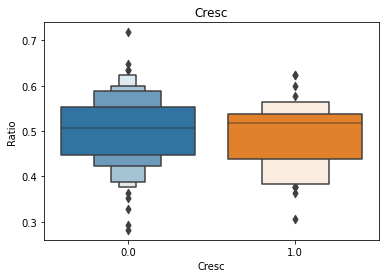

  Source  ddof1  ddof2         F     p-unc       np2
0  Cresc      1    255  0.604436  0.437611  0.002365


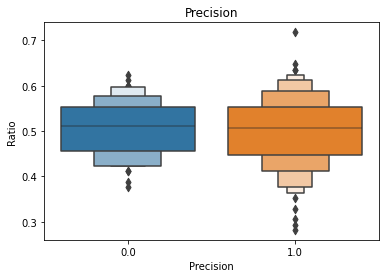

      Source  ddof1  ddof2         F     p-unc       np2
0  Precision      1    255  0.397083  0.529164  0.001555


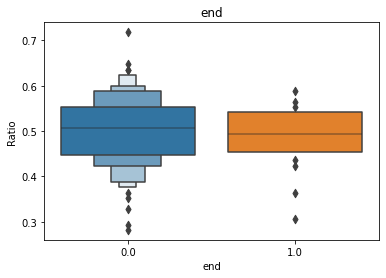

  Source  ddof1  ddof2         F     p-unc       np2
0    end      1    255  0.950521  0.330511  0.003714


In [49]:
features = ['cues', 'Type', 'Gap', 'Rest', 'Connect',
       'Voices_dec', 'Note_rate_dec', 'Drone', 'TextInc', 'Phr_end',
       'Phr_begining', 'Elide', 'Sequence', 'Rubato', 'Rit', 'Fermata',
       'Tempo_inc', 'Diminuendo', 'Fp/Fz', 'Cresc', 'Precision', 'end']

for feat in features:
#feat = 'Gap'
    sns.boxenplot(x = feat,y = 'Ratio', data = Still_times)
    plt.title(feat)
    plt.show()

    print(pg.anova(dv="Ratio",between = feat, data=Still_times))

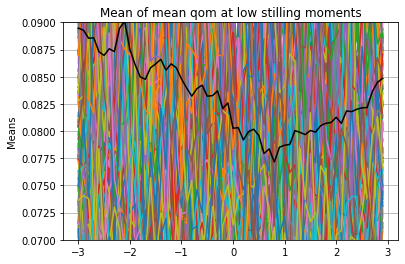

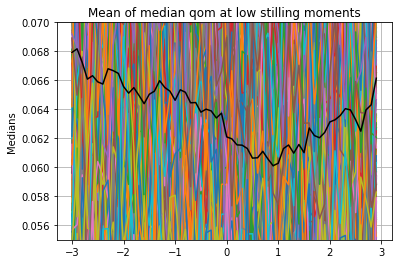

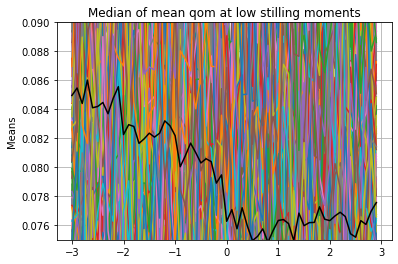

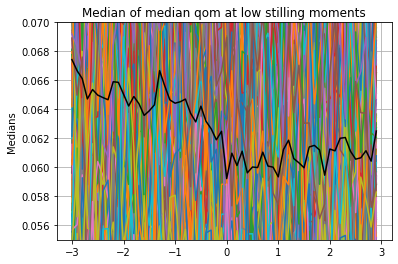

In [94]:
Part_times = Part_Still.copy()
# extract the distribution of average movement in some seconds before each still time and in/after
meanQM = seg_df.mean(axis=1)

snips = pd.DataFrame(index = np.arange(-3,3, 0.1),columns = Part_times.index)

for i in range(len(Part_times)-1):
    sm = Part_times.iloc[i,:]
    Otime = sm.name
    snips.loc[:,Otime]=meanQM.loc[Otime-3.025:Otime+2.975].values
snips.plot(legend = False)
snips.mean(axis=1).plot(color = 'k',legend = False)
plt.title('Mean of mean qom at low stilling moments')
plt.ylim([0.07,0.09])
plt.ylabel('Means')

plt.grid()
plt.show()

# extract the distribution of average movement in some seconds before each still time and in/after
meanQM = seg_df.median(axis=1)

snips = pd.DataFrame(index = np.arange(-3,3, 0.1),columns = Part_times.index)

for i in range(len(Part_times)-1):
    sm = Part_times.iloc[i,:]
    Otime = sm.name
    snips.loc[:,Otime]=meanQM.loc[Otime-3.025:Otime+2.975].values
snips.plot(legend = False)
snips.mean(axis=1).plot(color = 'k',legend = False)
plt.title('Mean of median qom at low stilling moments')

plt.ylim([0.055,0.07])
plt.ylabel('Medians')
plt.grid()
plt.show()


# extract the distribution of average movement in some seconds before each still time and in/after
meanQM = seg_df.mean(axis=1)

snips = pd.DataFrame(index = np.arange(-3,3, 0.1),columns = Part_times.index)

for i in range(len(Part_times)-1):
    sm = Part_times.iloc[i,:]
    Otime = sm.name
    snips.loc[:,Otime]=meanQM.loc[Otime-3.025:Otime+2.975].values
snips.plot(legend = False)
snips.median(axis=1).plot(color = 'k',legend = False)
plt.title('Median of mean qom at low stilling moments')
plt.ylim([0.075,0.09])
plt.ylabel('Means')

plt.grid()
plt.show()

# extract the distribution of average movement in some seconds before each still time and in/after
meanQM = seg_df.median(axis=1)

snips = pd.DataFrame(index = np.arange(-3,3, 0.1),columns = Part_times.index)

for i in range(len(Part_times)-1):
    sm = Part_times.iloc[i,:]
    Otime = sm.name
    snips.loc[:,Otime]=meanQM.loc[Otime-3.025:Otime+2.975].values
snips.plot(legend = False)
snips.median(axis=1).plot(color = 'k',legend = False)
plt.title('Median of median qom at low stilling moments')
plt.ylim([0.055,0.07])
plt.ylabel('Medians')
plt.grid()
plt.show()

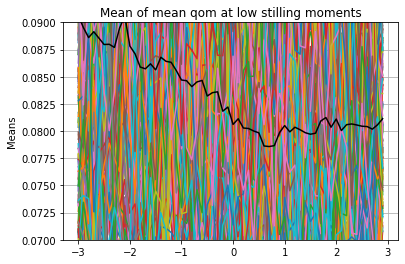

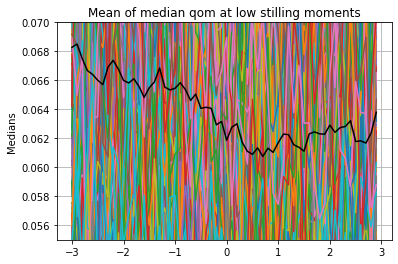

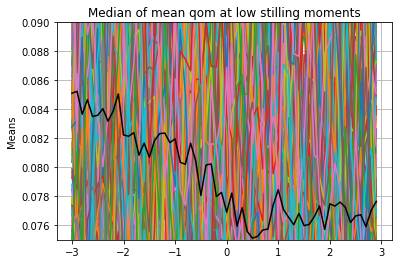

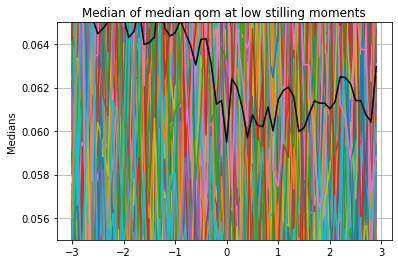

In [51]:
Part_times = Part_Still.copy()
# extract the distribution of average movement in some seconds before each still time and in/after
meanQM = seg_df.mean(axis=1)

snips = pd.DataFrame(index = np.arange(-3,3, 0.1),columns = Part_times.index)

for i in range(len(Part_times)-1):
    sm = Part_times.iloc[i,:]
    Otime = sm.name
    snips.loc[:,Otime]=meanQM.loc[Otime-3.025:Otime+2.975].values
snips.plot(legend = False)
snips.mean(axis=1).plot(color = 'k',legend = False)
plt.title('Mean of mean qom at low stilling moments')
plt.ylim([0.07,0.09])
plt.ylabel('Means')

plt.grid()
plt.show()

# extract the distribution of average movement in some seconds before each still time and in/after
meanQM = seg_df.median(axis=1)

snips = pd.DataFrame(index = np.arange(-3,3, 0.1),columns = Part_times.index)

for i in range(len(Part_times)-1):
    sm = Part_times.iloc[i,:]
    Otime = sm.name
    snips.loc[:,Otime]=meanQM.loc[Otime-3.025:Otime+2.975].values
snips.plot(legend = False)
snips.mean(axis=1).plot(color = 'k',legend = False)
plt.title('Mean of median qom at low stilling moments')

plt.ylim([0.055,0.07])
plt.ylabel('Medians')
plt.grid()
plt.show()


# extract the distribution of average movement in some seconds before each still time and in/after
meanQM = seg_df.mean(axis=1)

snips = pd.DataFrame(index = np.arange(-3,3, 0.1),columns = Part_times.index)

for i in range(len(Part_times)-1):
    sm = Part_times.iloc[i,:]
    Otime = sm.name
    snips.loc[:,Otime]=meanQM.loc[Otime-3.025:Otime+2.975].values
snips.plot(legend = False)
snips.median(axis=1).plot(color = 'k',legend = False)
plt.title('Median of mean qom at low stilling moments')
plt.ylim([0.075,0.09])
plt.ylabel('Means')

plt.grid()
plt.show()

# extract the distribution of average movement in some seconds before each still time and in/after
meanQM = seg_df.median(axis=1)

snips = pd.DataFrame(index = np.arange(-3,3, 0.1),columns = Part_times.index)

for i in range(len(Part_times)-1):
    sm = Part_times.iloc[i,:]
    Otime = sm.name
    snips.loc[:,Otime]=meanQM.loc[Otime-3.025:Otime+2.975].values
snips.plot(legend = False)
snips.median(axis=1).plot(color = 'k',legend = False)
plt.title('Median of median qom at low stilling moments')
plt.ylim([0.055,0.065])
plt.ylabel('Medians')
plt.grid()
plt.show()

In [106]:
i

246

# New exatraction criteria?

Use two features of the audio to identify potential stillness moments across the pieces. 

Combine note onset density and amplitude envelope

In [53]:
seg_tag = 'Schnittke'
seg_start = Main_concert_times.iloc[17,0]
seg_end = Main_concert_times.iloc[20,0]
Still_times  = Stillings.loc[seg_start:seg_end].copy()

[seg_start,seg_end ]

[2054.48, 3282.36]

In [95]:
SoundAmp = pd.read_csv(general_loc + 'Stimuli/' + 'amplitude_env.csv')
# Onsets_stqt.csv midi_set.csv
#Stillings=Stillings.fillna(0)
SoundAmp= SoundAmp.set_index('TIME')
# SoundFeat  = SoundAmp.loc[seg_start:seg_end].copy()
ts_ft = np.arange(0,8945, 0.1)#*1000 
reSound = pd.DataFrame(index = ts_ft)
f = interpolate.interp1d(SoundAmp.index, SoundAmp.VALUE,fill_value='extrapolate')
reSound['SoundAmp'] = f(ts_ft)
# SoundFeat.iloc[:5,:]

In [96]:
ts_ft = np.arange(0,8942, 0.1)#*1000 
reSound = pd.DataFrame(index = ts_ft)
f = interpolate.interp1d(SoundAmp.index, SoundAmp.VALUE,fill_value='extrapolate')
reSound['SoundAmp'] = f(ts_ft)/0.25

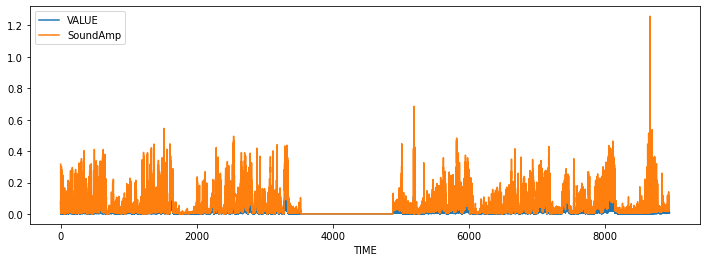

In [97]:
fig,ax = plt.subplots(1,1,figsize=[12,4] )
SoundAmp.plot(ax=ax)
reSound.plot(ax=ax)
plt.show()

,VALUE,LABEL
TIME,,
57.90,220.0000,[1] A3
57.92,233.0820,[1] A#3
57.94,246.9420,[1] B3
58.32,246.9420,[1] B3
59.10,69.2957,[1] C#2


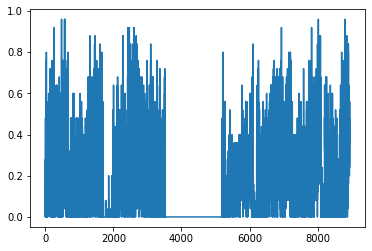

In [98]:
Onsets = pd.read_csv(general_loc + 'Stimuli/' + 'Onsets_stqt.csv')
OnsetsII = pd.read_csv(general_loc + 'Stimuli/' + 'Onsets_stqt5188p287.csv')
OnsetsII['TIME'] = OnsetsII['TIME']+ 5188.287
Onsets = pd.concat([Onsets,OnsetsII])
# Onsets_stqt.csv midi_set.csv 5188.287  Onsets_stqt5188p287.csv
Onsets= Onsets.set_index('TIME')
SoundFeat  = Onsets.loc[seg_start:seg_end].copy()
wind = 1
counts = []
for t in ts_ft:
    counts.append(len(Onsets.loc[t:t+wind]))
    
reSound['OnsetRate'] = np.array(counts)/25 
reSound['OnsetRate'].plot()
SoundFeat.iloc[:5,:]

In [99]:
reSound

,SoundAmp,OnsetRate
0.0,0.316675,0.16
0.1,0.105875,0.12
0.2,0.054245,0.12
0.3,0.036024,0.12
0.4,0.014686,0.12
...,...,...
8941.5,0.052361,0.44
8941.6,0.079211,0.48
8941.7,0.042663,0.36
8941.8,0.054823,0.36


This uses a plug in in sonic visualiser to get the approximate note onsets. Silvet note transcription, with string quartet settings. the result isn't a perfect eval of each note, but it does seem to vary reasonably in time. Designed for multi-instrumental onset detection, much better than the scared.

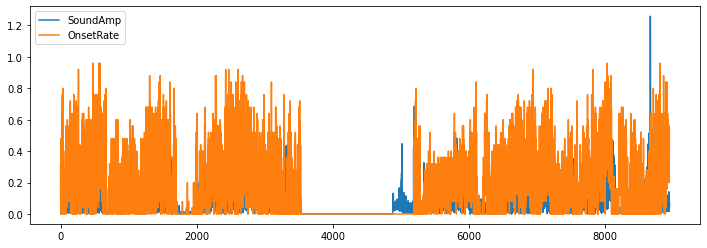

In [100]:
fig,ax = plt.subplots(1,1,figsize=[12,4] )
reSound.plot(ax=ax)
#reSound.plot(ax=ax)
plt.show()

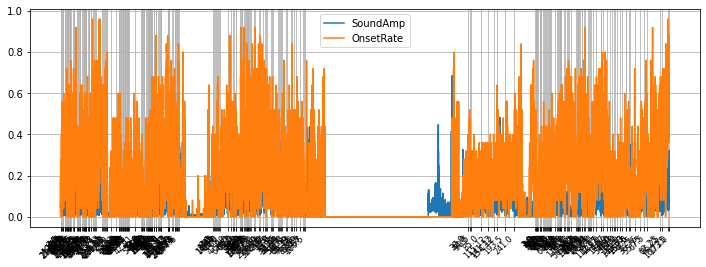

,SoundAmp,OnsetRate
SoundAmp,1.000000,0.589951
OnsetRate,0.589951,1.000000


In [101]:
SoundFeat  = reSound.loc[seg_start:seg_end].copy()
SoundFeat.plot(figsize=(12,4))
SoundFeat.corr(method='spearman')
plt.xticks(Still_times.index,Still_times.LABEL, rotation='45',fontsize=8, ha='right')
plt.grid()
plt.show()
SoundFeat.corr(method='spearman')

In [151]:
86*60+28+0.287

5188.287

## extract the features per instance


In [80]:
Still_times.columns

Index(['LABEL', 'Set', 'Movement', 'cues', 'Type', 'Gap', 'Rest', 'Connect',
       'Voices_dec', 'Note_rate_dec', 'Drone', 'TextInc', 'Phr_end',
       'Phr_begining', 'Elide', 'Sequence', 'Rubato', 'Rit', 'Fermata',
       'Tempo_inc', 'Diminuendo', 'Fp/Fz', 'Cresc', 'Precision', 'end',
       'OLDTIME'],
      dtype='object')

In [103]:
len(Still_times)

257

In [102]:
#fig,ax = plt.subplots(1,1,figsize=[14,4])
V = pd.DataFrame(index = Still_times.index)
SF = reSound['SoundAmp']
pre = []
post = []
ch = []
for i in range(len(Still_times.index)): # reSound
    sm = Still_times.iloc[i,:]
    Otime = sm.name
    pre_snip = SF.loc[Otime+preoff:Otime+preoff+1.0].mean()
    post_snip = SF.loc[Otime+postoff:Otime+postoff+1.0].mean()
    pre.append(pre_snip)
    post.append(post_snip)
    ch.append(post_snip-pre_snip)
V['SoundAmp_pre'] = pre
V['SoundAmp_post'] = post
V['SoundAmp_shift'] = ch

SF = reSound['OnsetRate']
pre = []
post = []
ch = []
for i in range(len(Still_times.index)): # reSound
    sm = Still_times.iloc[i,:]
    Otime = sm.name
    pre_snip = SF.loc[Otime+preoff:Otime+preoff+1.0].mean()
    post_snip = SF.loc[Otime+postoff:Otime+postoff+1.0].mean()
    
    pre.append(pre_snip)
    post.append(post_snip)
    ch.append(post_snip-pre_snip)

V['OnsetRate_pre'] = pre
V['OnsetRate_post'] = post
V['OnsetRate_shift'] = ch




In [104]:
SF = seg_df.mean(axis=1)
pre = []
post = []
ch = []
for i in range(len(Still_times.index)): # reSound
    sm = Still_times.iloc[i,:]
    Otime = sm.name
    pre_snip = SF.loc[Otime+preoff:Otime+preoff+1.0].mean()
    post_snip = SF.loc[Otime+postoff:Otime+postoff+1.0].mean()
    pre.append(pre_snip)
    post.append(post_snip)
    ch.append(post_snip-pre_snip)

V['QoMmean_pre'] = pre
V['QoMmean_post'] = post
V['QoMmean_shift'] = ch

SF = seg_df.median(axis=1)
pre = []
post = []
ch = []
for i in range(len(Still_times.index)): # reSound
    sm = Still_times.iloc[i,:]
    Otime = sm.name
    pre_snip = SF.loc[Otime+preoff:Otime+preoff+1.0].mean()
    post_snip = SF.loc[Otime+postoff:Otime+postoff+1.0].mean()
    pre.append(pre_snip)
    post.append(post_snip)
    ch.append(post_snip-pre_snip)

V['QoMmedian_pre'] = pre
V['QoMmedian_post'] = post
V['QoMmedian_shift'] = ch


In [105]:
V.corr(method ='spearman')

,SoundAmp_pre,SoundAmp_post,SoundAmp_shift,OnsetRate_pre,OnsetRate_post,OnsetRate_shift,QoMmean_pre,QoMmean_post,QoMmean_shift,QoMmedian_pre,QoMmedian_post,QoMmedian_shift
SoundAmp_pre,1.000000,0.561640,-0.894024,0.442682,0.190328,-0.251164,0.429175,0.327271,-0.141053,0.486851,0.426976,-0.080492
SoundAmp_post,0.561640,1.000000,-0.222996,0.397789,0.404093,-0.063431,0.349060,0.370319,-0.048370,0.430838,0.521055,0.095109
SoundAmp_shift,-0.894024,-0.222996,1.000000,-0.335039,-0.041687,0.268948,-0.328180,-0.227148,0.107061,-0.362406,-0.278669,0.107593
OnsetRate_pre,0.442682,0.397789,-0.335039,1.000000,0.275826,-0.620124,0.285824,0.278537,-0.012279,0.392692,0.398520,0.009107
OnsetRate_post,0.190328,0.404093,-0.041687,0.275826,1.000000,0.493743,0.241903,0.220884,-0.092479,0.253241,0.310179,0.079982
OnsetRate_shift,-0.251164,-0.063431,0.268948,-0.620124,0.493743,1.000000,-0.057515,-0.069350,-0.049232,-0.142181,-0.124866,0.044501
QoMmean_pre,0.429175,0.349060,-0.328180,0.285824,0.241903,-0.057515,1.000000,0.685284,-0.439453,0.837189,0.642901,-0.264073
QoMmean_post,0.327271,0.370319,-0.227148,0.278537,0.220884,-0.069350,0.685284,1.000000,0.253692,0.639784,0.804480,0.179764
QoMmean_shift,-0.141053,-0.048370,0.107061,-0.012279,-0.092479,-0.049232,-0.439453,0.253692,1.000000,-0.300455,0.085037,0.572310
QoMmedian_pre,0.486851,0.430838,-0.362406,0.392692,0.253241,-0.142181,0.837189,0.639784,-0.300455,1.000000,0.726261,-0.375454


<AxesSubplot:xlabel='TIME'>

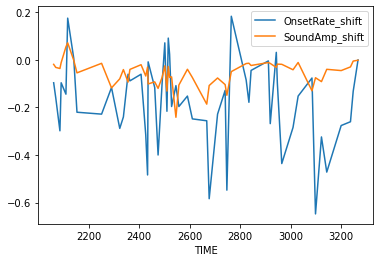

In [62]:
V.loc[:,['OnsetRate_shift','SoundAmp_shift']].plot()

In [106]:
still_feats = pd.concat([Still_times,V],axis=1)
still_feats.to_csv('ReTagged_Stillings_with_Audio.csv')

In [107]:
print(still_feats.columns)
still_feats.corr(method='spearman')

Index(['LABEL', 'Set', 'Movement', 'cues', 'Type', 'Gap', 'Rest', 'Connect',
       'Voices_dec', 'Note_rate_dec', 'Drone', 'TextInc', 'Phr_end',
       'Phr_begining', 'Elide', 'Sequence', 'Rubato', 'Rit', 'Fermata',
       'Tempo_inc', 'Diminuendo', 'Fp/Fz', 'Cresc', 'Precision', 'end',
       'OLDTIME', 'Ratio', 'SoundAmp_pre', 'SoundAmp_post', 'SoundAmp_shift',
       'OnsetRate_pre', 'OnsetRate_post', 'OnsetRate_shift', 'QoMmean_pre',
       'QoMmean_post', 'QoMmean_shift', 'QoMmedian_pre', 'QoMmedian_post',
       'QoMmedian_shift'],
      dtype='object')


,LABEL,Set,Movement,cues,Gap,Rest,Connect,Voices_dec,Note_rate_dec,Drone,...,SoundAmp_shift,OnsetRate_pre,OnsetRate_post,OnsetRate_shift,QoMmean_pre,QoMmean_post,QoMmean_shift,QoMmedian_pre,QoMmedian_post,QoMmedian_shift
LABEL,1.000000,-0.075410,-0.006713,0.103510,0.013660,0.154017,-0.006302,0.190296,0.148464,-0.012990,...,-0.239779,0.262754,0.199576,-0.056000,0.049823,0.120736,0.076926,0.184848,0.178888,-0.000051
Set,-0.075410,1.000000,-0.453753,-0.142083,-0.149053,-0.245705,0.164106,0.043623,0.212604,0.184291,...,0.019116,-0.055308,0.172845,0.248734,0.125352,0.103229,-0.051552,-0.066046,-0.114590,-0.014660
Movement,-0.006713,-0.453753,1.000000,-0.028193,0.063901,0.202159,-0.056506,0.013359,-0.125823,0.110180,...,-0.044532,0.117866,-0.214327,-0.240583,-0.152886,-0.141740,0.061825,-0.053994,-0.026536,0.017241
cues,0.103510,-0.142083,-0.028193,1.000000,0.488871,0.244725,-0.409179,0.450261,-0.222518,-0.144680,...,-0.076704,0.060132,-0.012506,-0.056728,-0.013912,0.012470,0.058131,0.011476,-0.000987,0.009539
Gap,0.013660,-0.149053,0.063901,0.488871,1.000000,0.480078,-0.945393,-0.386581,-0.284522,-0.475739,...,-0.008301,-0.015762,-0.166891,-0.067669,-0.071871,-0.087107,0.030577,-0.114532,-0.168540,-0.034675
Rest,0.154017,-0.245705,0.202159,0.244725,0.480078,1.000000,-0.518126,-0.178229,-0.253594,-0.124839,...,-0.082468,0.060740,-0.149873,-0.103004,-0.017167,-0.041940,0.010974,-0.042592,-0.070081,-0.011843
Connect,-0.006302,0.164106,-0.056506,-0.409179,-0.945393,-0.518126,1.000000,0.425288,0.261485,0.510404,...,-0.019641,0.031406,0.157558,0.040069,0.051255,0.079088,-0.011868,0.102404,0.163427,0.034765
Voices_dec,0.190296,0.043623,0.013359,0.450261,-0.386581,-0.178229,0.425288,1.000000,0.040600,0.342822,...,-0.118540,0.093054,0.082468,-0.039864,0.037660,0.105427,0.075845,0.107421,0.143717,0.020666
Note_rate_dec,0.148464,0.212604,-0.125823,-0.222518,-0.284522,-0.253594,0.261485,0.040600,1.000000,0.220704,...,0.001389,-0.099927,0.065404,0.126118,-0.001136,-0.018053,-0.060597,-0.011614,-0.040524,-0.035979
Drone,-0.012990,0.184291,0.110180,-0.144680,-0.475739,-0.124839,0.510404,0.342822,0.220704,1.000000,...,0.041124,-0.047784,-0.071953,-0.019844,-0.059009,-0.044388,0.016450,-0.069323,-0.018799,0.020888


In [65]:
SF = seg_df.mean(axis=1)

SF.to_csv('mean.csv')


In [108]:

Cond = ['Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall'] #,'Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual'] # hall for 85 and virtual for 30
seg_df.columns.values
Event_ranges = {'Beethoven 1':[8,9],'Beethoven 2':[9,10],'Beethoven 3':[10,11],'Beethoven 4':[11,12],'Schnittke 1':[17,18],'Schnittke 2':[18,19],'Schnittke 3':[19,20],'Bach':[28,29],'Folk 1':[33,34],'Folk 2':[35,36],'Folk 3':[38,39],'Folk 4':[41,42],'Folk 5':[44,45],'Folk 6':[50,51]}

#Event_ranges = {'Beethoven':[8,12],'Schnittke':[17,20],'Bach':[28,29],'Folk 1':[33,34],'Folk 2':[35,36],'Folk 3':[38,39],'Folk 4':[41,42],'Folk 5':[44,45],'Folk 6':[50,51]}
mm_df = pd.DataFrame(columns=['Participant','Condition','Music','mQoM'])
for ev in Event_ranges:
    print(ev)
    if ev.startswith('Bee'):
        sec = 'First Half'
    else:
        if ev.startswith('Sch'):
            sec = 'First Half'
        else:
            sec = 'Second Half'
    mdf = pd.DataFrame(columns=['Participant','Condition','Music','mQoM'])
    mdf['Participant']= seg_df.columns.values
    mdf['Condition'] = Cond
    mdf['Music'] = ev
    mdf['Halfs'] = sec
    seg_start = Main_concert_times.iloc[Event_ranges[ev][0],0]
    seg_end = Main_concert_times.iloc[Event_ranges[ev][1],0]
    mdf.loc[:,'mQoM'] = aud_df.loc[seg_start:seg_end,:].copy().mean(skipna=True).values
    mm_df = pd.concat([mm_df,mdf])

#mm_df

Beethoven 1
Beethoven 2
Beethoven 3
Beethoven 4
Schnittke 1
Schnittke 2
Schnittke 3
Bach
Folk 1
Folk 2
Folk 3
Folk 4
Folk 5
Folk 6


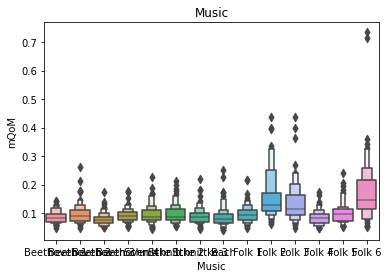

  Source  ddof1  ddof2          F         p-unc       ng2       eps
0  Music     13    845  39.508536  3.557913e-78  0.257362  0.173638


In [67]:
sns.boxenplot(x = 'Music',y = 'mQoM', data = mm_df)
plt.title('Music')
#plt.savefig('plots/PairCorr_allEvents_Proximity.png',dpi = 400)
plt.show()
aov = pg.rm_anova(dv='mQoM',within = 'Music',subject='Participant', data=mm_df)
print(aov)

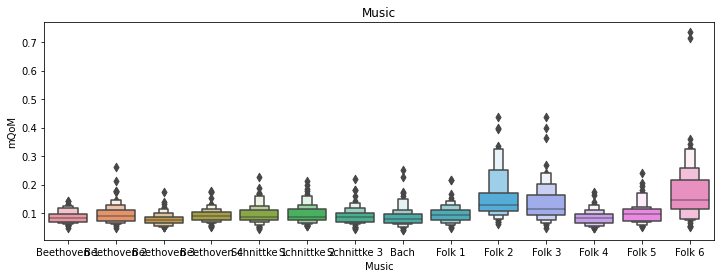

  Source  ddof1  ddof2          F         p-unc       ng2       eps
0  Music     13    845  39.508536  3.557913e-78  0.257362  0.173638


In [68]:
f, (ax1) = plt.subplots(1, 1, sharey=True,figsize=(12,4))
sns.boxenplot(x = 'Music',y = 'mQoM', data = mm_df.loc[mm_df['Condition']=='Hall',:],ax=ax1)
plt.title('Music')
#plt.savefig('plots/PairCorr_allEvents_Proximity.png',dpi = 400)
plt.show()
aov = pg.rm_anova(dv='mQoM',within = 'Music',subject='Participant', data=mm_df)
print(aov)

# decrease statistics

In [109]:
Event_ranges = {'Beethoven':[8,12],'Schnittke':[17,20],'Bach':[28,29],'Folk 1':[33,34],'Folk 2':[35,36],'Folk 3':[38,39],'Folk 4':[41,42],'Folk 5':[44,45],'Folk 6':[50,51]}
mov_df = pd.DataFrame(columns = seg_df.columns,index=Event_ranges.keys())
seg_df = aud_df.copy()
mus_df = pd.DataFrame(columns = seg_df.columns)

#seg_df = seg_df.fillna(0)
for ev in Event_ranges:
    print(ev)
    seg_start = Main_concert_times.iloc[Event_ranges[ev][0],0]
    seg_end = Main_concert_times.iloc[Event_ranges[ev][1],0]
    mov_df.loc[ev,:] = seg_df.loc[seg_start:seg_end,:].copy().mean(skipna=True)
    mus_df  = pd.concat([mus_df,seg_df.loc[seg_start:seg_end,:].copy()])
music_index = mus_df.index
mov_df


Beethoven
Schnittke
Bach
Folk 1
Folk 2
Folk 3
Folk 4
Folk 5
Folk 6


,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,AEQ081,AEQ082,AEQ083,AEQ084,AEQ085,AEQ086,AEQ087,AEQ088,AEQ089,AER090
Beethoven,0.06931,NaN,0.094418,0.101832,0.073396,0.108571,0.079436,0.086551,0.078944,0.132908,...,0.106828,0.071494,0.078133,0.064631,0.119277,NaN,0.073233,0.093535,0.08919,0.093232
Schnittke,NaN,NaN,0.09243,0.143005,0.082105,0.117091,0.071236,0.084851,0.083309,0.106298,...,0.093283,0.061849,0.087554,0.071892,0.105193,NaN,0.061135,0.069501,0.086059,0.094612
Bach,0.056344,0.135227,0.095909,0.124162,0.076236,0.103214,0.072805,0.075117,0.063814,0.103792,...,0.081876,0.065726,0.074377,NaN,0.111408,0.042212,0.067237,0.049843,0.086903,0.100428
Folk 1,0.092763,0.108706,0.113461,0.11108,0.091294,0.094409,0.108131,0.100647,0.06888,0.128617,...,0.09879,0.074521,0.138157,NaN,0.145356,0.059401,0.06019,0.06832,0.104448,0.11132
Folk 2,0.107179,0.112969,0.134227,0.16998,0.132951,0.109864,0.169403,0.1276,0.103629,0.278259,...,0.153714,0.118163,0.32582,NaN,0.400411,0.147357,0.077057,0.198442,0.128659,0.116878
Folk 3,0.093821,0.110445,0.120349,0.200489,0.09407,0.122745,0.134144,0.181669,0.076284,0.200711,...,0.166426,0.105396,0.231518,NaN,NaN,0.047903,0.06436,0.064405,0.103357,0.127553
Folk 4,0.058239,0.104601,0.105789,0.106932,0.100064,0.093399,0.107378,0.071827,0.066724,0.08968,...,0.081129,0.048081,0.110477,NaN,NaN,0.126884,0.053554,0.052202,0.11264,0.092117
Folk 5,0.076783,0.113608,0.109129,0.2069,0.112852,0.092305,0.087781,0.09075,0.077657,0.171621,...,0.097739,0.062379,0.113193,NaN,NaN,0.086016,0.067918,0.053534,0.105256,0.111599
Folk 6,0.131336,0.122249,0.17015,0.278143,0.105464,0.129512,0.164427,0.115135,0.096362,0.254176,...,0.237071,0.137488,NaN,NaN,0.734506,0.053553,0.078747,0.05254,0.150831,0.124459


In [110]:
V_df = pd.DataFrame(index = music_index)
seg_df = aud_df.copy()
seg_df = seg_df.fillna(0)
k=[]
for i in music_index:
    pre_snip_df = seg_df.loc[i+preoff:i+preoff+1.0].mean(axis=0).values
    post_snip_df = seg_df.loc[i++postoff:i++postoff+1].mean(axis=0).values
    k.append(sum((post_snip_df-pre_snip_df)<0)/len(pre_snip_df))
V_df['Ratio'] = k

<AxesSubplot:>

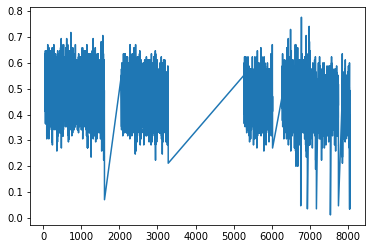

In [111]:
V_df.plot(legend = False)

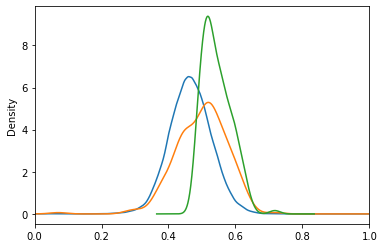

In [112]:
V_df.loc[:,'Ratio'].plot.kde()
Still_times.loc[:,'Ratio'].plot.kde()

Part_Still.loc[:,'Ratio'].plot.kde()

plt.xlim([0,1])
plt.show()

In [113]:
Still_times

,LABEL,Set,Movement,cues,Type,Gap,Rest,Connect,Voices_dec,Note_rate_dec,...,Rit,Fermata,Tempo_inc,Diminuendo,Fp/Fz,Cresc,Precision,end,OLDTIME,Ratio
TIME,,,,,,,,,,,,,,,,,,,,,
61.32,2.50,1,1,3.0,pause,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,61.32,0.376471
65.84,4.50,1,1,3.0,pause,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,65.84,0.564706
79.02,10.25,1,1,3.0,pause,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,79.02,0.588235
88.75,13.00,1,1,3.0,close,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,88.26,0.517647
95.79,17.50,1,1,4.0,dropin,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,95.78,0.411765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7744.49,67.50,8,1,2.0,end,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,7744.90,0.458824
7916.48,62.25,9,1,1.0,retract,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,7916.20,0.482353
7943.42,86.25,9,1,1.0,drop,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7942.63,0.423529


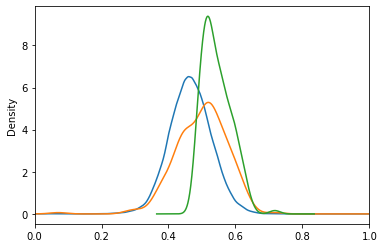

In [114]:
V_df.loc[:,'Ratio'].plot.kde()
still_feats.loc[:,'Ratio'].plot.kde()

Part_Still.loc[:,'Ratio'].plot.kde()

plt.xlim([0,1])
plt.show()

In [77]:
still_feats.columns

Index(['LABEL', 'Set', 'Movement', 'cues', 'Type', 'Gap', 'Rest', 'Connect',
       'Voices_dec', 'Note_rate_dec', 'Drone', 'TextInc', 'Phr_end',
       'Phr_begining', 'Elide', 'Sequence', 'Rubato', 'Rit', 'Fermata',
       'Tempo_inc', 'Diminuendo', 'Fp/Fz', 'Cresc', 'Precision', 'end',
       'OLDTIME', 'SoundAmp_pre', 'SoundAmp_post', 'SoundAmp_shift',
       'OnsetRate_pre', 'OnsetRate_post', 'OnsetRate_shift', 'QoMmean_pre',
       'QoMmean_post', 'QoMmean_shift', 'QoMmedian_pre', 'QoMmedian_post',
       'QoMmedian_shift'],
      dtype='object')

In [56]:
print([Part_Still.loc[:,'Ratio'].median(),V_df.loc[:,'Ratio'].median()])
sp.stats.ks_2samp(Part_Still.loc[:,'Ratio'], V_df.loc[:,'Ratio'], alternative='less')

[0.5294117647058824, 0.47058823529411764]


KstestResult(statistic=0.5719336361840806, pvalue=8.971074564158304e-47)

So by komolgrov-smirnoff test, the distribution of decreased ratios is higher at the identified stilling point than through the music generally. This is without reduction from initial score/audio criteria, not yet culling the Fps and finales for example. The difference isn't big, but it's significant and encouraging. Reason to reassess criteria for misleading results. 

In [113]:
Still_times.columns

Index(['LABEL', 'Set', 'Movement', 'Moment', 'Since', 'Type', 'end',
       'Sequence', 'Rest', 'Gap', 'Connect', 'Elide', 'Phr_end',
       'Phr_begining', 'Rubato', 'Rit', 'Fermata', 'Precision', 'Cresc', 'Fp',
       'Diminuendo', 'TextDec', 'Drone', 'TextInc', 'revisedT', 'old_TIME',
       'old_Ratio', 'Ratio'],
      dtype='object')

In [119]:
print(Part_Still.loc[Part_Still.Ratio<=0.47058823529411764,['revisedT', 'old_Ratio', 'Ratio']].mean())
Part_Still.loc[Part_Still.Ratio<=0.47058823529411764,['LABEL', 'Set', 'Movement', 'Moment','revisedT', 'old_TIME',
       'old_Ratio', 'Ratio']]

revisedT     0.592105
old_Ratio    0.429977
Ratio        0.432663
dtype: float64


,LABEL,Set,Movement,Moment,revisedT,old_TIME,old_Ratio,Ratio
TIME,,,,,,,,
61.320000,2.5,1,1,1,0,61.320,0.382609,0.411765
96.042667,17 x,1,1,5,1,94.808,0.408696,0.423529
149.893000,46,1,1,12,0,149.893,0.408696,0.411765
291.192000,113.5,1,1,27,0,291.192,0.382609,0.388235
333.648000,135,1,1,30,0,333.648,0.452174,0.470588
...,...,...,...,...,...,...,...,...
7517.610000,x,7,1,238,0,7517.610,0.408696,0.376471
7588.470000,x,8,1,240,0,7588.470,0.382609,0.400000
7660.992000,New Point,8,1,241,1,7660.480,0.426087,0.411765


In [58]:
#Reduced_Still = Still_times.loc[Still_times.Ratio>0.47058823529411764,:]
Reduced_Still = Still_times.loc[Still_times.Ratio>0.50,:]
print(Reduced_Still['Ratio'].min())
len(Reduced_Still)

0.5058823529411764


133

In [59]:
trick_V_df = V_df.loc[V_df.loc[:,'Ratio']>Reduced_Still['Ratio'].min(),'Ratio']
len(trick_V_df)/len(V_df)

0.22385937191388505

In [60]:
trick_V_df

57.4      0.541176
57.5      0.576471
57.6      0.576471
57.7      0.576471
57.8      0.564706
            ...   
8037.6    0.564706
8037.7    0.517647
8037.8    0.541176
8037.9    0.552941
8038.0    0.517647
Name: Ratio, Length: 11334, dtype: float64

In [260]:
# sample rate 10 hz, so offsets translated to integers are 5-3=2, 5+28-3 = 30
drop_df = aud_df.rolling(10,center=True).mean().shift(periods=0-3) - aud_df.rolling(10,center=True).mean().shift(periods=28-3) #1 second average, reported at end of window

In [274]:
# verifying that the indexing corrections went the right way
k_df = drop_df.loc[np.round(Still_times.index,1),:].copy().fillna(0)
check=pd.DataFrame(index=k_df.index)
k_df=k_df.mask(k_df>=0, 0)
k_df=k_df.mask(k_df<0, 1)
check['Ratio'] = k_df.mean(axis=1)
check['Prop_R'] = Still_times['Ratio'].values
print(check[['Ratio','Prop_R']].mean())
print(check[['Ratio','Prop_R']].corr())
check[['Ratio','Prop_R']]

# as close as we can get. The differences is from the fact that the Still_times are higher precision 
# than the sample rate and end up rounding differently in the previous analysis. 

Ratio     0.485306
Prop_R    0.505978
dtype: float64
           Ratio    Prop_R
Ratio   1.000000  0.880014
Prop_R  0.880014  1.000000


,Ratio,Prop_R
TIME,,
61.3,0.352941,0.411765
65.8,0.552941,0.552941
79.0,0.517647,0.552941
88.7,0.552941,0.541176
96.0,0.458824,0.423529
...,...,...
7744.5,0.435294,0.458824
7916.5,0.494118,0.529412
7943.4,0.388235,0.423529


In [ ]:
# now k_df has the participantion 

# Patterns of quieting in individuals
we have the drop features throughout the whole recording, so now to check on how individuals decrease

In [61]:
# sample rate 10 hz, so offsets translated to integers are 5-3=2, 5+28-3 = 30
drop_df = aud_df.rolling(10,center=True).mean().shift(periods=0-3) - aud_df.rolling(10,center=True).mean().shift(periods=28-3) #1 second average, reported at end of window

In [62]:
thresh = 0

test_df = drop_df.loc[music_index,:].copy().fillna(0)
test_df=test_df.mask(test_df>=thresh, 0)
test_df=test_df.mask(test_df<thresh, 1)


In [63]:
k_df = drop_df.loc[np.round(Still_times.index,1),:].copy().fillna(0)
check=pd.DataFrame(index=k_df.index)
k_df=k_df.mask(k_df>=0, 0)
k_df=k_df.mask(k_df<0, 1)

Text(0.5, 1.0, 'Hist of participation in silences.')

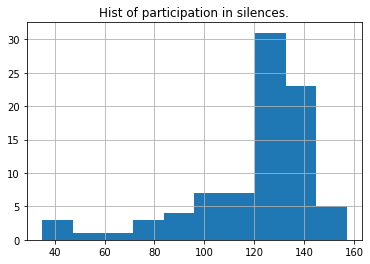

In [64]:
k_df.sum(axis=0).hist()
plt.title('Hist of participation in silences.') 
# most more than half

In [65]:
k_df = drop_df.loc[np.round(Part_times.index,1),:].copy().fillna(0)
check=pd.DataFrame(index=k_df.index)
k_df=k_df.mask(k_df>=0, 0)
k_df=k_df.mask(k_df<0, 1)

In [73]:
k_df

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,AEQ081,AEQ082,AEQ083,AEQ084,AEQ085,AEQ086,AEQ087,AEQ088,AEQ089,AER090
TIME,,,,,,,,,,,,,,,,,,,,,
65.8,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
79.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
88.7,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
111.6,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
115.3,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7263.5,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
7297.7,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7315.4,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


# TODO
from here, get the ratio of stillings participated in per participant per section and over all. Note that this is just decrease, might fail to catch those already not moving. Not sure we can conpensate for that.

So close Finn. 

In [76]:
# ranges for each piece 
co_stillings = pd.DataFrame(index = k_df.columns)

In [77]:
co_stillings['Full Concert']=k_df.sum(axis=0)/len(k_df)
co_stillings

,Full Concert
ADQ001,0.438272
ADQ002,0.160494
ADQ003,0.543210
ADQ004,0.549383
ADQ005,0.518519
...,...
AEQ086,0.129630
AEQ087,0.574074
AEQ088,0.567901
AEQ089,0.549383


In [78]:
Event_ranges = {'Beethoven 1':[8,9],'Beethoven 2':[9,10],'Beethoven 3':[10,11],'Beethoven 4':[11,12],'Schnittke 1':[17,18],'Schnittke 2':[18,19],'Schnittke 3':[19,20],'Bach':[28,29],'Folk 1':[33,34],'Folk 2':[35,36],'Folk 3':[38,39],'Folk 4':[41,42],'Folk 5':[44,45],'Folk 6':[50,51]}


In [85]:
tag = 'Beethoven'
seg_start = Main_concert_times.iloc[8,0]
seg_end = Main_concert_times.iloc[12,0]
sub_k = k_df.loc[seg_start:seg_end,:]
print(len(sub_k))
co_stillings[tag] = sub_k.sum(axis=0)/len(sub_k)


87


In [86]:
tag = 'Schnittke'
seg_start = Main_concert_times.iloc[17,0]
seg_end = Main_concert_times.iloc[20,0]
sub_k = k_df.loc[seg_start:seg_end,:]
print(len(sub_k))
co_stillings[tag] = sub_k.sum(axis=0)/len(sub_k)
co_stillings

31


,Full Concert,Beethoven,Schnittke,Bach,Folk
ADQ001,0.438272,0.563218,0.000000,0.6,0.487179
ADQ002,0.160494,0.000000,0.000000,0.2,0.641026
ADQ003,0.543210,0.551724,0.580645,0.4,0.512821
ADQ004,0.549383,0.517241,0.548387,0.6,0.615385
ADQ005,0.518519,0.505747,0.419355,0.8,0.589744
...,...,...,...,...,...
AEQ086,0.129630,0.000000,0.000000,0.6,0.461538
AEQ087,0.574074,0.517241,0.677419,0.8,0.589744
AEQ088,0.567901,0.551724,0.483871,1.0,0.615385
AEQ089,0.549383,0.609195,0.419355,0.4,0.538462


In [87]:
tag = 'Bach'
seg_start = Main_concert_times.iloc[28,0]
seg_end = Main_concert_times.iloc[29,0]
sub_k = k_df.loc[seg_start:seg_end,:]
print(len(sub_k))

co_stillings[tag] = sub_k.sum(axis=0)/len(sub_k)


5


In [88]:
tag = 'Folk'
seg_start = Main_concert_times.iloc[33,0]
seg_end = Main_concert_times.iloc[51,0]
sub_k = k_df.loc[seg_start:seg_end,:]
print(len(sub_k))

co_stillings[tag] = sub_k.sum(axis=0)/len(sub_k)
co_stillings

39


,Full Concert,Beethoven,Schnittke,Bach,Folk
ADQ001,0.438272,0.563218,0.000000,0.6,0.487179
ADQ002,0.160494,0.000000,0.000000,0.2,0.641026
ADQ003,0.543210,0.551724,0.580645,0.4,0.512821
ADQ004,0.549383,0.517241,0.548387,0.6,0.615385
ADQ005,0.518519,0.505747,0.419355,0.8,0.589744
...,...,...,...,...,...
AEQ086,0.129630,0.000000,0.000000,0.6,0.461538
AEQ087,0.574074,0.517241,0.677419,0.8,0.589744
AEQ088,0.567901,0.551724,0.483871,1.0,0.615385
AEQ089,0.549383,0.609195,0.419355,0.4,0.538462


In [84]:
co_stillings.corr()

,Full Concert,Beethoven,Schnittke,Bach,Folk
Full Concert,1.000000,0.812254,0.772545,0.419369,0.574012
Beethoven,0.812254,1.000000,0.556585,0.114548,0.076973
Schnittke,0.772545,0.556585,1.000000,0.284903,0.242442
Bach,0.419369,0.114548,0.284903,1.000000,0.447042
Folk,0.574012,0.076973,0.242442,0.447042,1.000000


In [89]:
co_stillings.to_csv('./data/Stilling_ratios.csv')

Text(0.5, 1.0, 'Hist of participation in Common silences.')

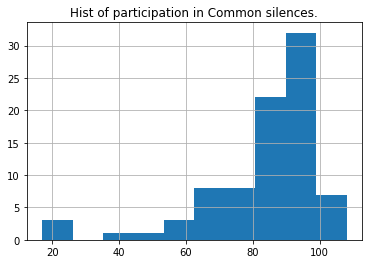

In [66]:
k_df.sum(axis=0).hist()
plt.title('Hist of participation in Common silences.') 
# most more than half

<AxesSubplot:ylabel='Density'>

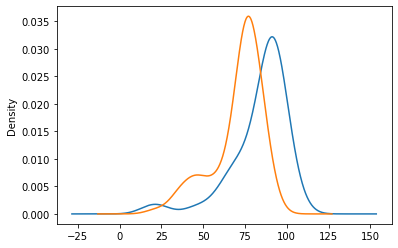

In [70]:
k_df.sum(axis=0).plot.kde()
test_df.sample(n=len(k_df), random_state=1).sum(axis=0).plot.kde()


(0.0, 85.0)

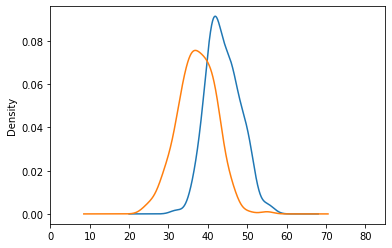

In [71]:
k_df.sum(axis=1).plot.kde()
test_df.sample(n=247, random_state=1).sum(axis=1).plot.kde()
plt.xlim([0,len(k_df.columns)])

In [72]:
trick_test_df = test_df.loc[test_df.mean(axis=1)>Reduced_Still['Ratio'].min(),:]
len(trick_test_df)/len(test_df)

0.1423464349200079

In [307]:
g_df = drop_df.loc[np.round(Reduced_Still.index,1),:].copy().fillna(0)
g_df=g_df.mask(g_df>=0, 0)
g_df=g_df.mask(g_df<0, 1)

(0.0, 85.0)

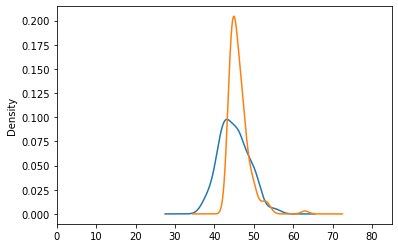

In [308]:
g_df.sum(axis=1).plot.kde()
trick_test_df.sample(n=len(g_df), random_state=1).sum(axis=1).plot.kde()
plt.xlim([0,len(g_df.columns)])

# Most or more quiet

A complication in the analysis is that it seems sometimes the participants are at the lowest they can be, movement wise. Can we combine this "already still" state with the "getting more still" state as well?

Example: count when participant is in their lowest 10% of movement AND when they are decreasing from 3 s ago. 

In [236]:
seg_tag = 'Full_Concert'
seg_start = Main_concert_times.iloc[8,0]
seg_end = Main_concert_times.iloc[51,0]

[seg_start,seg_end ]
seg_df = aud_df.loc[seg_start:seg_end,:].copy()
seg_df = seg_df.fillna(0)


In [233]:
Lims_1 = mus_df.quantile(0.1) 

#s.quantile(np.linspace(.1, 1, 9, 0), 'lower')

In [241]:
A = pd.DataFrame(columns=seg_df.columns,index=seg_df.index,data=0)
for c in seg_df.columns:
    A.loc[seg_df.loc[:,c]<Lims_1[c],c]=1

<AxesSubplot:>

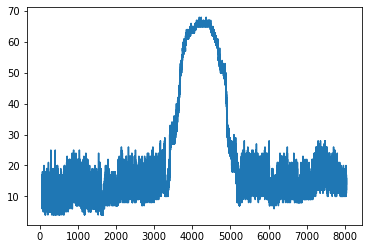

In [242]:
A.sum(axis=1).plot()

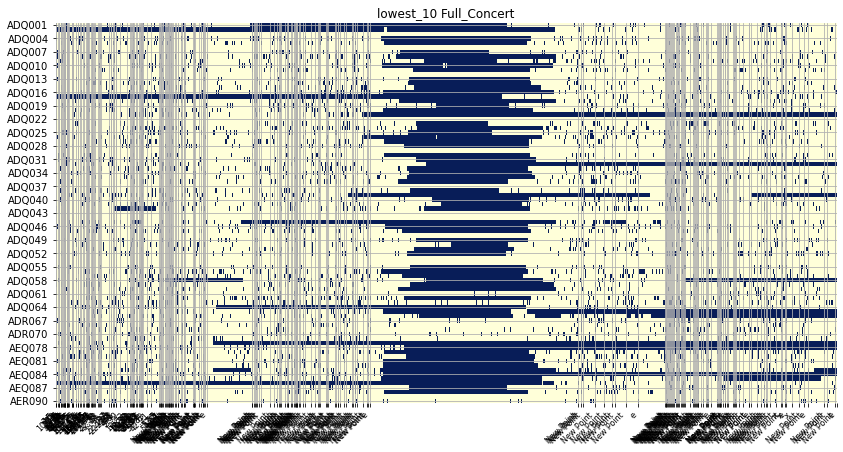

In [243]:
fig, (ax1) = plt.subplots(1, 1,figsize = [14,7])
chart = sns.heatmap(data=A.transpose(), ax=ax1,vmin=0, vmax=1,cbar=False, cmap="YlGnBu")

new_xticks = len(A)*(Still_times.index - seg_start)/(seg_end-seg_start)
plt.xticks(new_xticks,Still_times['LABEL'], rotation='45',fontsize=8, ha='right')
plt.grid()
# ax1.set_xticks(new_xticks)
# #ax1.set_xticklabels(seg_times['Event'])
# ax1.set_xticklabels(cmoments['Event'])
plt.title('lowest_10 ' + seg_tag)
#plt.savefig('./Plots/qom_n_full.png',dpi = 300)
plt.show()


In [240]:
seg_df

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,AEQ081,AEQ082,AEQ083,AEQ084,AEQ085,AEQ086,AEQ087,AEQ088,AEQ089,AER090
57.4,0.060309,0.000000,0.113149,0.184463,0.072030,0.100000,0.060223,0.063567,0.049057,0.070111,...,0.270043,0.024067,0.053916,0.095521,0.086229,0.000000,0.046746,0.053319,0.159755,0.197411
57.5,0.064529,0.000000,0.100000,0.100000,0.063241,0.100000,0.205743,0.060659,0.061561,0.087698,...,0.108041,0.106984,0.095672,0.052941,0.080227,0.000000,0.119140,0.024193,0.635523,0.110051
57.6,0.094745,0.000000,0.109152,0.100000,0.011666,0.147059,0.225949,0.037976,0.082458,0.059192,...,0.128982,0.104687,0.028388,0.048428,0.049676,0.000000,0.072693,0.132163,0.563718,0.129824
57.7,0.092638,0.000000,0.043750,0.202151,0.022169,0.153429,0.369144,0.028182,0.077309,0.033213,...,0.077944,0.063161,0.040323,0.080898,0.079386,0.000000,0.067796,0.146493,0.181142,0.102263
57.8,0.132872,0.000000,0.070833,0.104236,0.025996,0.122793,0.802898,0.043572,0.063336,0.036641,...,0.119808,0.031347,0.042491,0.053424,0.063230,0.000000,0.057156,0.056633,0.161634,0.086514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8041.8,0.193695,0.035294,0.259091,0.025000,0.040422,0.070833,0.039460,0.097529,0.058709,0.127360,...,0.233510,0.513886,0.000000,0.000000,0.040424,0.048125,0.075648,0.041904,0.000000,0.060322
8041.9,0.131861,0.064706,0.091508,0.075000,0.039982,0.070833,0.063608,0.046914,0.047584,0.080633,...,0.260689,0.168126,0.000000,0.000000,0.031011,0.058212,0.037663,0.023144,0.000000,0.053405
8042.0,0.084923,0.176960,0.073706,0.072222,0.075722,0.100000,0.075927,0.048123,0.057115,0.141243,...,0.153771,0.155607,0.000000,0.000000,0.027935,0.077741,0.149488,0.025882,0.000000,0.051561
8042.1,0.076554,0.111454,0.100000,0.027778,0.043302,0.100000,0.053096,0.046315,0.046225,0.038260,...,0.122845,0.608408,0.000000,0.000000,0.071759,0.032081,0.177650,0.026097,0.100000,0.010549


(2054.48, 3282.36)

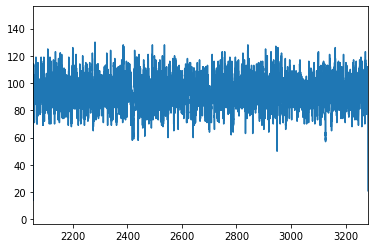

In [255]:
A.sum(axis=1).plot()
ev = 'Schnittke'
plt.xlim([Main_concert_times.iloc[Event_ranges[ev][0],0],Main_concert_times.iloc[Event_ranges[ev][1],0]])

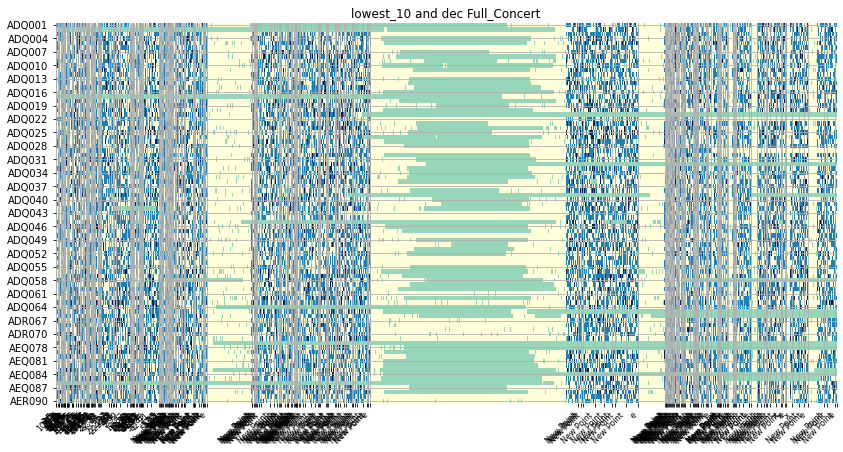

In [247]:
fig, (ax1) = plt.subplots(1, 1,figsize = [14,7])
chart = sns.heatmap(data=A.transpose(), ax=ax1,vmin=0, vmax=3,cbar=False, cmap="YlGnBu")

new_xticks = len(A)*(Still_times.index - seg_start)/(seg_end-seg_start)
plt.xticks(new_xticks,Still_times['LABEL'], rotation='45',fontsize=8, ha='right')
plt.grid()
# ax1.set_xticks(new_xticks)
# #ax1.set_xticklabels(seg_times['Event'])
# ax1.set_xticklabels(cmoments['Event'])
plt.title('lowest_10 and dec ' + seg_tag)
#plt.savefig('./Plots/qom_n_full.png',dpi = 300)
plt.show()


In [276]:
i

6530.5

Need a threshold for decreases to be counted here for the personwise judgments and threshold for motion still or super still. 

In [275]:
decs_df = pd.DataFrame(index = music_index,columns=seg_df.columns,data = 0)
for i in music_index:
    pre_snip_df = aud_df.loc[i-3:i-2].mean(axis=0).values
    post_snip_df = aud_df.loc[i+0:i+1].mean(axis=0).values
    decs_df.loc[i,:]=post_snip_df-pre_snip_df
decs_df # = decs_df.fillna(0)

KeyboardInterrupt: 

In [261]:
decs_df

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,AEQ081,AEQ082,AEQ083,AEQ084,AEQ085,AEQ086,AEQ087,AEQ088,AEQ089,AER090
57.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8041.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8041.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8042.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8042.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [262]:
pre_snip_df

array([0.03354342, 0.09547028, 0.09272245, 0.09036029, 0.06303503,
       0.13799972, 0.10577747, 0.04396694, 0.06890026, 0.04474234,
       0.10368185, 0.12382327, 0.04666857, 0.09486728, 0.05457764,
       0.12195149, 0.05927773, 0.06867295, 0.09075169, 0.09885844,
       0.        , 0.14788671, 0.0759108 , 0.12060101, 0.18375457,
       0.13322208, 0.09325436, 0.04766286, 0.08082756, 0.11062666,
       0.05573963, 0.        , 0.10000232, 0.07627352, 0.09043013,
       0.03534298, 0.06140665, 0.08190331, 0.11731192, 0.06124645,
       0.13343581, 0.07604854, 0.14880647, 0.10871302, 0.00778274,
       0.06490405, 0.09536521, 0.06250356, 0.27686468, 0.11928073,
       0.0673484 , 0.05577603, 0.04946706, 0.08800284, 0.32635089,
       0.06322924, 0.76379918, 0.        , 0.04024738, 0.07119641,
       0.07111945, 0.        , 0.05955495, 0.06941566, 0.        ,
       0.        , 0.06666658, 0.08371698, 0.0439705 , 0.03090468,
       0.08295973, 0.        , 0.        , 0.04113278, 0.04162

In [273]:
i = 500
aud_df.loc[i-3:i-2].mean()

ADQ001    0.052124
ADQ002         NaN
ADQ003    0.053933
ADQ004    0.093474
ADQ005    0.113318
            ...   
AEQ086         NaN
AEQ087    0.067750
AEQ088    0.077089
AEQ089    0.059189
AER090    0.087622
Length: 85, dtype: float64